In [1]:
import fsps
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv
from scipy import interpolate

matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [2]:
sp = fsps.StellarPopulation(compute_vega_mags=False,zcontinuous=1,sfh=0,logzsol=0.0,dust_type=2,dust2=0.2)


In [3]:
age = 0.5 #Gyr
z = 3 #redshift
print(sp.libraries)

sdss_bands = fsps.find_filter('sdss')
print(sdss_bands)

print(sp.get_mags(tage=age, bands=sdss_bands))
sp.params['logzsol'] = -1

print(sp.get_mags(tage=age, bands=sdss_bands))
wave, spec = sp.get_spectrum(tage=age,peraa=True)

(b'pdva', b'miles')
['sdss_i', 'sdss_z', 'sdss_g', 'sdss_u', 'sdss_r']
[ 4.03628976  3.90720404  4.35212426  5.65132907  4.15019322]
[ 3.88921064  3.8268405   4.1407593   5.14744303  3.97991823]


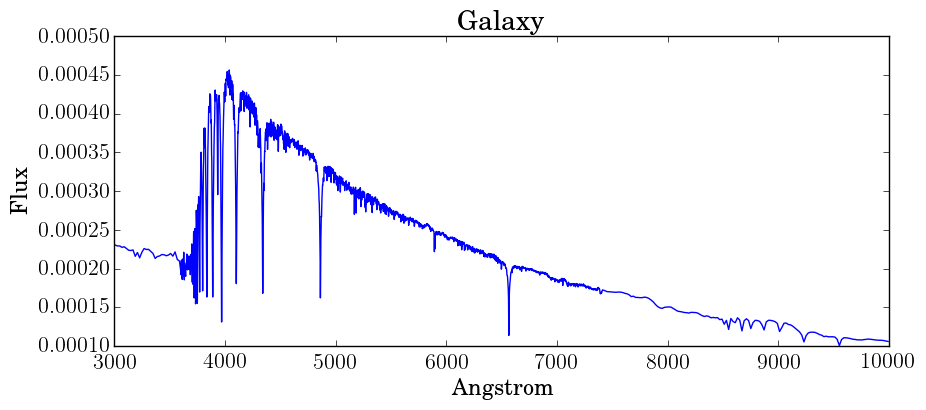

In [4]:
indices = np.where((wave>=3000) & (wave<= 10000))

useWave,useSpec = wave[indices],spec[indices]
# useWave = useWave * (z+1) #### For now just testing with optical filters
useSpec = useSpec #want line flux to be conserved

fig = plt.figure(figsize=(10, 4)) 
plt.plot(useWave,useSpec)
plt.title("Galaxy")
plt.xlabel("Angstrom")
plt.ylabel("Flux")
plt.show()

In [5]:
# Load an HST filters
# Filter test
class hst_filter:
    def __init__(self, name, wavelength, transmittance):
        self.name = name
        self.wavelength = wavelength
        self.transmittance = transmittance
        
    def __str__(self):
        return str(self.name)

filter_file_names = ["wfc_F435W", "wfc_F606W", "wfc_F775W", "wfc_F850LP"]
friendly_filter_names = ["WFC F435W", "WFC F606W", "WFC F775W", "WFC F850LP"]
hst_filters = {}

scale = np.max(useSpec)*2.0
for index,fname in enumerate(filter_file_names):
    with open(("HST_filters/%s.dat" % fname),"r") as data:
        reader = csv.reader(data, delimiter=" ")
        wv = []
        t = []
        for row in reader:
            wv.append(float(row[0])) # wavelength
            t.append(float(row[1])) # transmittance  * scale

        hst_filters[friendly_filter_names[index]] = hst_filter(friendly_filter_names[index],wv,t)

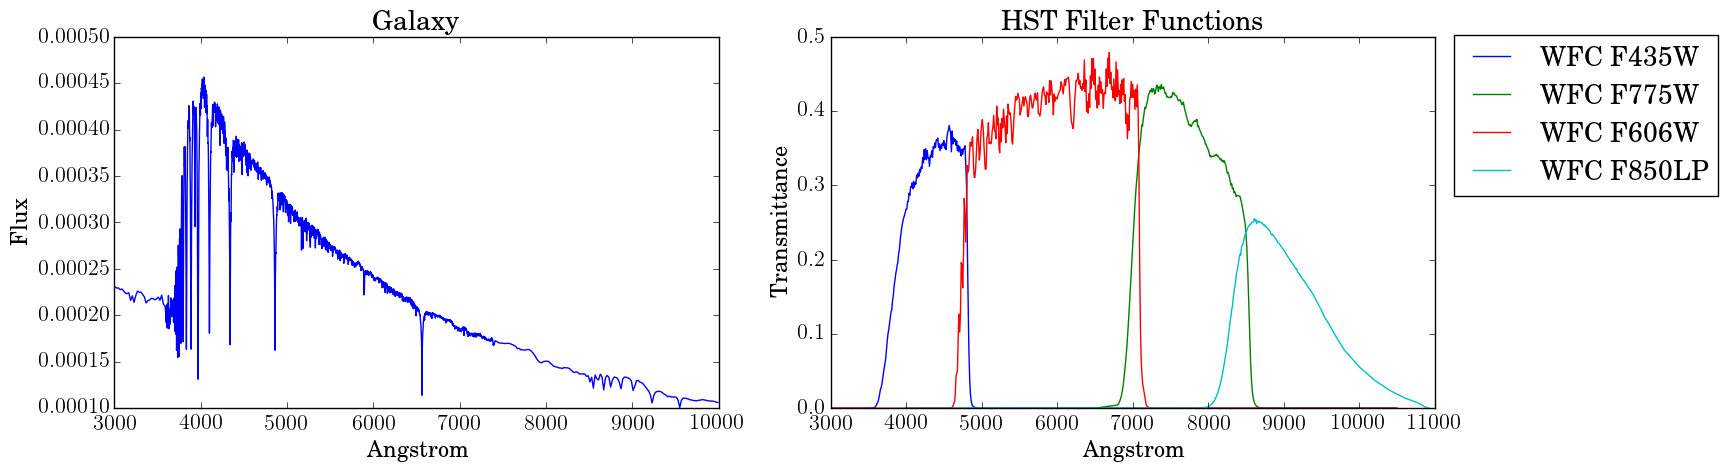

In [6]:
fig = plt.figure(figsize=(15, 5)) 

plt.subplot(1,2,1)
plt.plot(useWave,useSpec)
plt.title("Galaxy")
plt.xlabel("Angstrom")
plt.ylabel("Flux")

plt.subplot(1,2,2)
for flt_name in hst_filters:
    plt.plot(hst_filters[flt_name].wavelength,hst_filters[flt_name].transmittance, label=flt_name)
plt.title("HST Filter Functions")
plt.xlabel("Angstrom")
plt.ylabel("Transmittance")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2)

plt.tight_layout()    
plt.show()

In [7]:
for flt_name in hst_filters:
    
    print("filter: %s; lambda_min: %s; lambda_max: %s" % (flt_name, hst_filters[flt_name].wavelength[0],hst_filters[flt_name].wavelength[-1]))
    
    delta_lam = hst_filters[flt_name].wavelength[2] - hst_filters[flt_name].wavelength[1]
    print("delta_lambda: %s" % delta_lam)
    
    print("Len: %s" % len(hst_filters[flt_name].wavelength))
    
    # Pad "short" arrays (totally hard-coded... 
    # just experimenting with making array the same breadth as the spectra wavelength array)
    if len(hst_filters[flt_name].wavelength) < 7000:
        hst_filters[flt_name].wavelength = np.pad(hst_filters[flt_name].wavelength,(1000,0),'linear_ramp',end_values=(3000,3999))
        hst_filters[flt_name].transmittance = np.pad(hst_filters[flt_name].transmittance,(1000,0),'constant',constant_values=(0,0))
        

filter: WFC F435W; lambda_min: 3000.0; lambda_max: 10500.0
delta_lambda: 1.0
Len: 7501
filter: WFC F775W; lambda_min: 4000.0; lambda_max: 10470.0
delta_lambda: 1.0
Len: 6471
filter: WFC F606W; lambda_min: 3000.0; lambda_max: 10500.0
delta_lambda: 1.0
Len: 7501
filter: WFC F850LP; lambda_min: 4000.0; lambda_max: 10924.0
delta_lambda: 1.0
Len: 6925


In [8]:
# Check that we padded correctly
for flt_name in hst_filters:
    
    print("filter: %s; lambda_min: %s; lambda_max: %s" % (flt_name, hst_filters[flt_name].wavelength[0],hst_filters[flt_name].wavelength[-1]))
    print("Len: %s" % len(hst_filters[flt_name].wavelength))

filter: WFC F435W; lambda_min: 3000.0; lambda_max: 10500.0
Len: 7501
filter: WFC F775W; lambda_min: 3000.0; lambda_max: 10470.0
Len: 7471
filter: WFC F606W; lambda_min: 3000.0; lambda_max: 10500.0
Len: 7501
filter: WFC F850LP; lambda_min: 3000.0; lambda_max: 10924.0
Len: 7925


In [9]:
bandpass_flux = {}

for flt_name in hst_filters:
    # Interpolate filter function to the size of the spectra input array
    filter_func = interpolate.interp1d(hst_filters[flt_name].wavelength, hst_filters[flt_name].transmittance)
    
    # Scale real flux by filter response
    bandpass_flux[flt_name] = filter_func(useWave)*useSpec

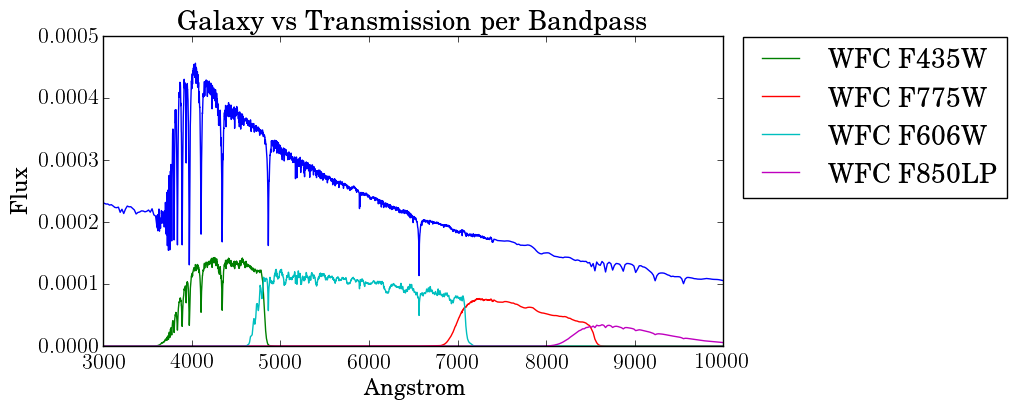

In [34]:
fig = plt.figure(figsize=(8, 4)) 

# Plot Spectra
plt.plot(useWave,useSpec)

phot_pts = []
# Overplot flux through each bandpass
for flt_name in hst_filters:
    plt.plot(useWave,bandpass_flux[flt_name],label=flt_name)    
    
    # Don't know if this is working... but I think it might be the general idea.
    phot_pts.append(np.sum(bandpass_flux[flt_name]))

plt.title("Galaxy vs Transmission per Bandpass")
plt.xlabel("Angstrom")
plt.ylabel("Flux")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2)
plt.show()

In [33]:
print(phot_pts)

[0.1343714446846023, 0.037268235195922567, 0.26193104133909811, 0.0018922030387175668]
